---
title: GE
subtitle: Análisis información
author: Jefe confiabilidad
date: 2025-03-21
---

In [1]:
from narwhals import DataFrame

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources.dplyr import *
from kdags.resources.tidyr import *
from io import BytesIO
import pdfplumber

# from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import *
import numpy as np

context = dg.build_asset_context()

from kdags.resources.ggplot import *
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from datetime import datetime

# result = kdefs.get_job_def("ge_job").execute_in_process(raise_on_error=False)

# Datos Events

Disponibles en:

https://globalkomatsu.sharepoint.com/sites/KCHCLSP00022/Shared%20Documents/01.%20%C3%81REAS%20KCH/1.6%20CONFIABILIDAD/CAEX/ANTECEDENTES/OPERATION/GE/events.csv

Data shape after filtering: (61624, 14)
Year range: 2022 to 2024

Yearly average failures:
   year  avg_failures  std_failures  equipment_count
0  2022    438.404762    275.803576               42
1  2023    471.391304    375.962674               46
2  2024    473.666667    419.917037               45

Selected equipment for monthly analysis: TK858 with 3965 failures


(<Figure size 1000x600 with 1 Axes>,
 <Figure size 1400x700 with 1 Axes>,
 <Figure size 1400x700 with 1 Axes>,
 <Figure size 1800x800 with 3 Axes>)

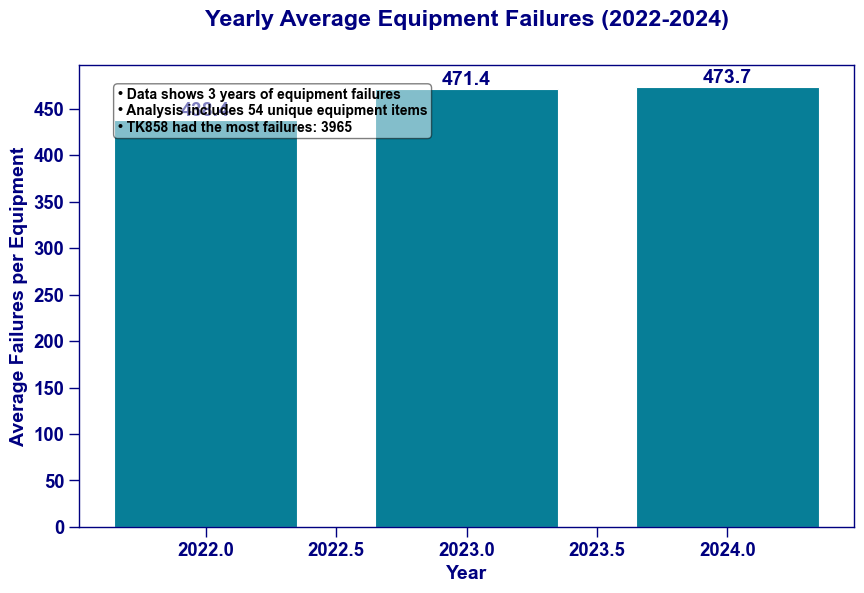

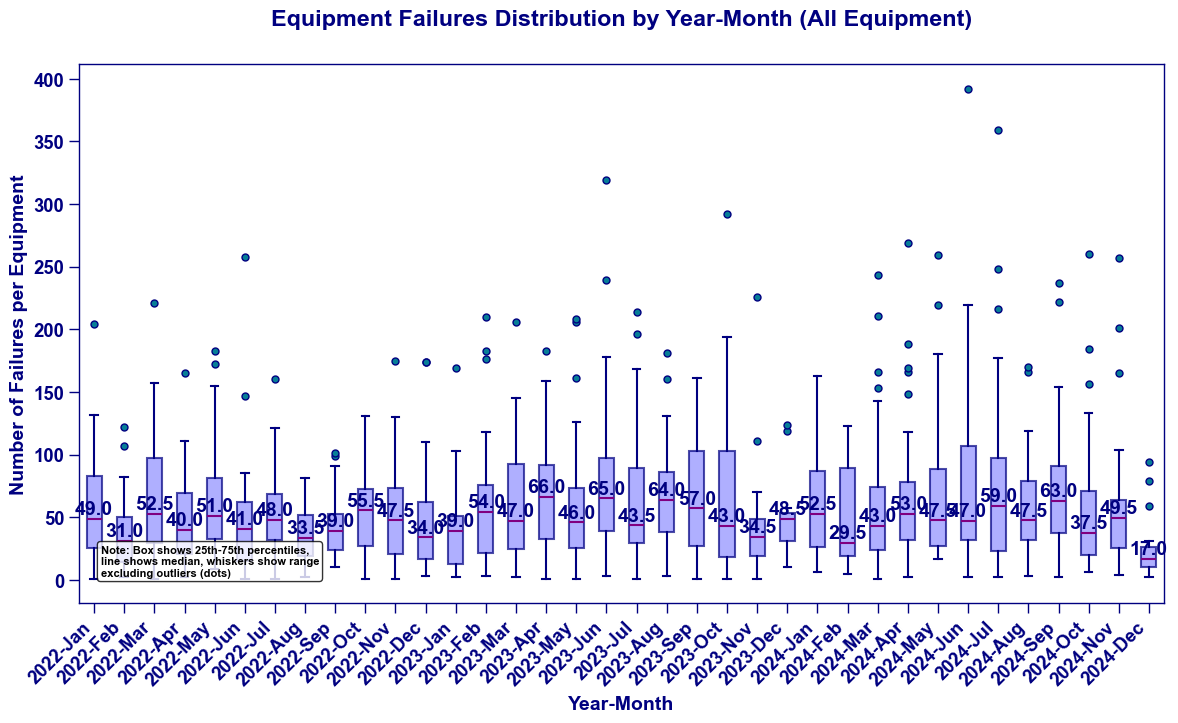

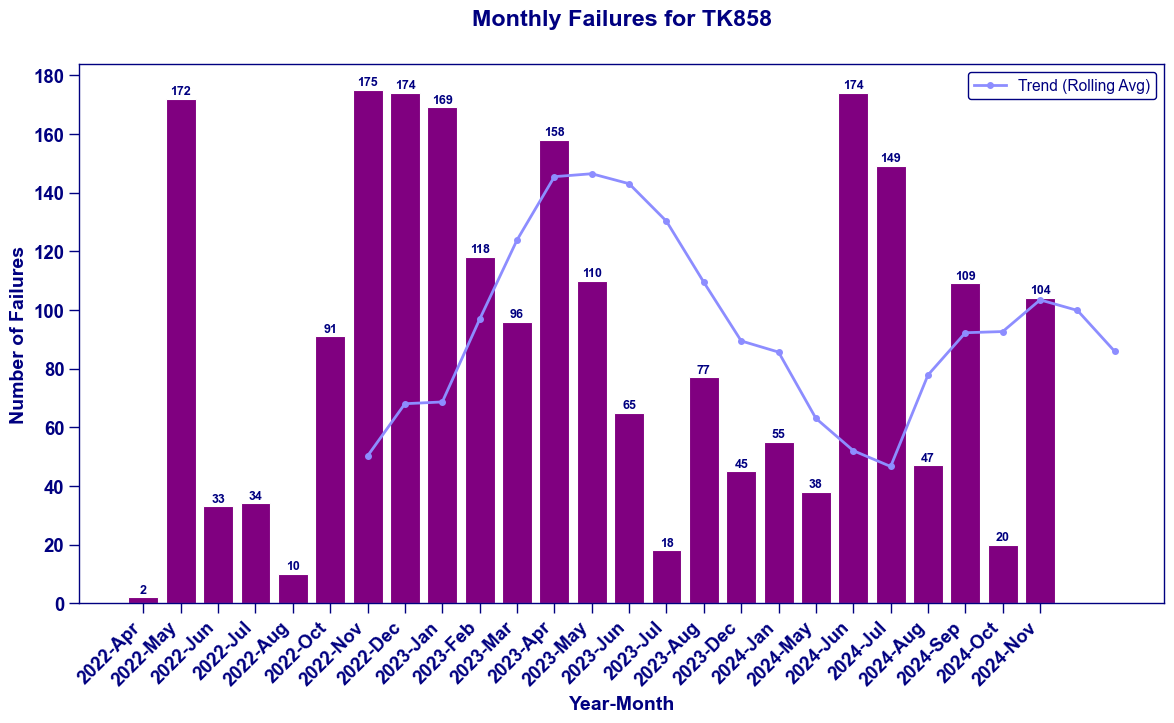

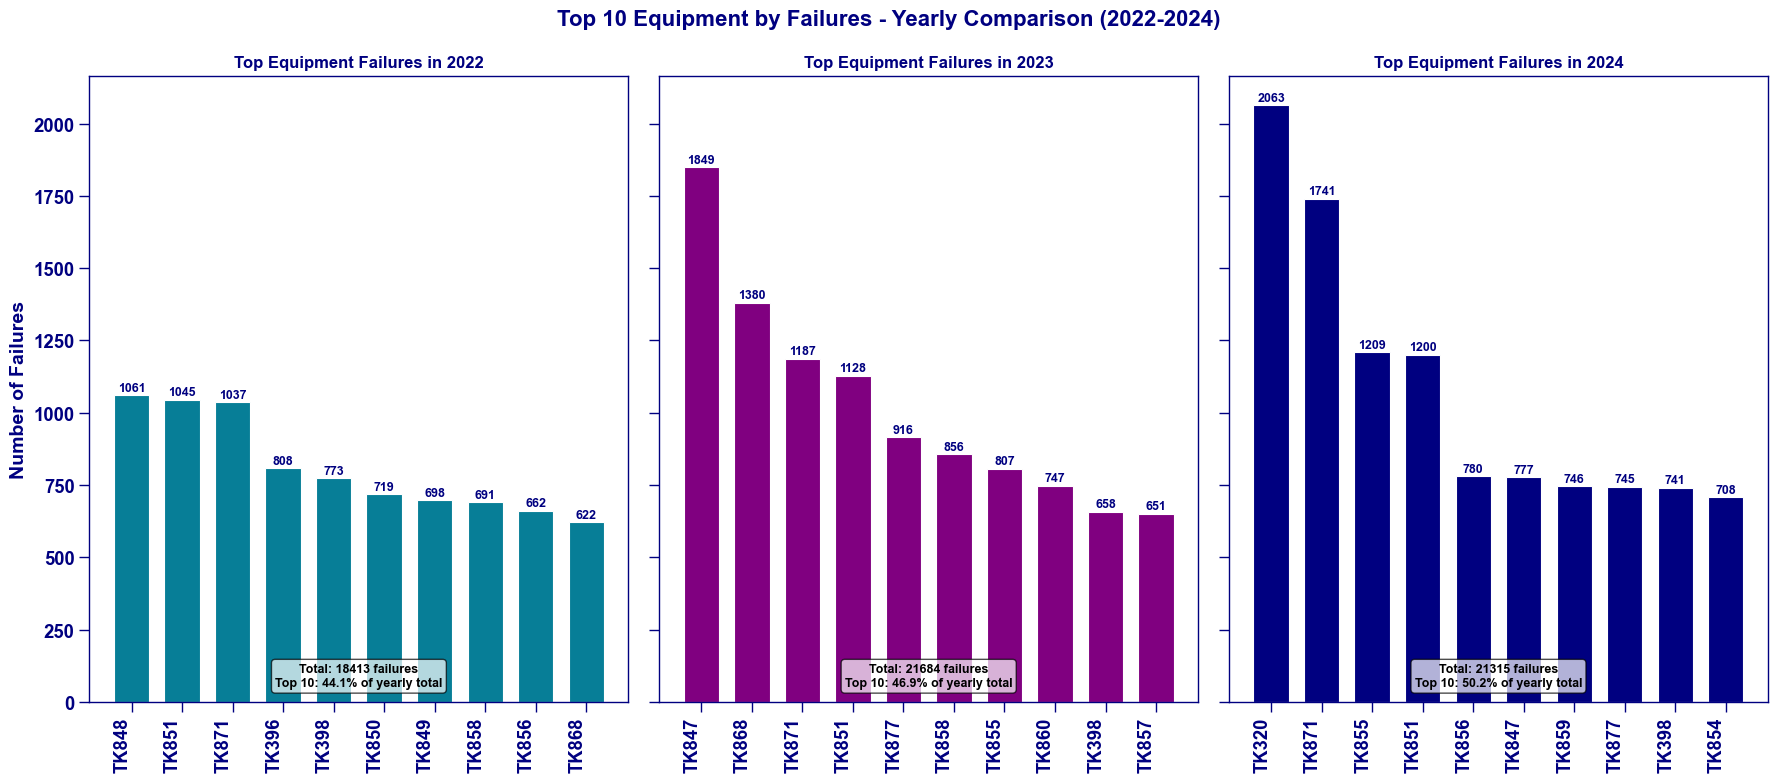

In [31]:
def create_yearly_top_equipment_plot(df, theme):
    """Create a plot showing top equipment by failures for each year"""
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate yearly failures by equipment
    yearly_equipment_failures = (
        df.groupby(["header_equipment_name", "year"])
        .size()
        .reset_index(name="failure_count")
    )

    # Create figure
    fig, axes = plt.subplots(
        1, 3, figsize=(18, 8), sharey=True
    )  # 3 subplots for 2022, 2023, 2024

    # Get unique years
    years = sorted(yearly_equipment_failures["year"].unique())

    # For each year, create a subplot with top equipment
    for i, year in enumerate(years):
        # Filter data for this year
        year_data = yearly_equipment_failures[yearly_equipment_failures["year"] == year]

        # Get top 10 equipment for this year
        top_equipment = year_data.nlargest(10, "failure_count")

        # Sort for better visualization (descending for vertical bar chart)
        top_equipment = top_equipment.sort_values("failure_count", ascending=False)

        # Create subplot for this year
        ax = axes[i]

        # Create bar chart
        bars = ax.bar(
            top_equipment["header_equipment_name"],
            top_equipment["failure_count"],
            color=theme.COLORS[i % len(theme.COLORS)],  # Different color for each year
            edgecolor="white",
            linewidth=0.8,
            width=0.7,
        )

        # Add data labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 5,
                f"{int(height)}",
                ha="center",
                va="bottom",
                color=theme.FIXED_COLORS["axis_title_color"],
                fontweight="bold",
                fontsize=9,
            )

        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right", fontsize=10)

        # Set title and axis labels
        ax.set_title(
            f"Top Equipment Failures in {year}",
            color=theme.FIXED_COLORS["plot_title_color"],
            fontweight="bold",
            fontsize=12,
        )

        ax.set_ylabel("Number of Failures" if i == 0 else "")

        # Add total count for this year
        total_failures = year_data["failure_count"].sum()
        top_failures = top_equipment["failure_count"].sum()
        percentage = (top_failures / total_failures) * 100

        ax.text(
            0.5,
            0.02,
            f"Total: {total_failures} failures\nTop 10: {percentage:.1f}% of yearly total",
            ha="center",
            va="bottom",
            transform=ax.transAxes,
            bbox=dict(facecolor="white", alpha=0.7, boxstyle="round"),
            fontsize=9,
        )

        # Apply theme styling
        theme.apply_theme(ax)

    # Set overall title
    fig.suptitle(
        "Top 10 Equipment by Failures - Yearly Comparison (2022-2024)",
        fontsize=16,
        fontweight="bold",
        color=theme.FIXED_COLORS["plot_title_color"],
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for the overall title

    # Save plot
    fig.savefig("yearly_top_equipment_comparison.png", dpi=300, bbox_inches="tight")

    return fig


def analyze_equipment_failures(df, sample_equipment):
    """Analyze equipment failures with corrected boxplot approach"""
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from datetime import datetime
    from kdags.resources.ggplot.ggprism import GGPrism

    # Convert datetime strings to datetime objects
    df["record_dt"] = pd.to_datetime(df["record_dt"])

    # Add year and month columns for analysis
    df["year"] = df["record_dt"].dt.year
    df["month"] = df["record_dt"].dt.month
    df["month_name"] = df["record_dt"].dt.strftime("%b")
    df["year_month"] = df["record_dt"].dt.strftime(
        "%Y-%m"
    )  # For grouping by year-month
    df["year_month_label"] = df["record_dt"].dt.strftime("%Y-%b")  # For display

    # Filter out years that seem like data errors (keeping 2020-2024)
    df = df[(df["year"] >= 2022) & (df["year"] <= 2024)]

    print(f"Data shape after filtering: {df.shape}")
    print(f"Year range: {df['year'].min()} to {df['year'].max()}")

    # Calculate yearly failures by equipment
    yearly_equipment_failures = (
        df.groupby(["header_equipment_name", "year"])
        .size()
        .reset_index(name="failure_count")
    )

    # Calculate overall yearly average failures across all equipment
    yearly_avg_failures = (
        yearly_equipment_failures.groupby("year")
        .agg(
            avg_failures=("failure_count", "mean"),
            std_failures=("failure_count", "std"),
            equipment_count=("failure_count", "count"),
        )
        .reset_index()
    )

    print("\nYearly average failures:")
    print(yearly_avg_failures)

    # Find equipment with most failures for monthly analysis
    equipment_failures = (
        df.groupby("header_equipment_name").size().reset_index(name="total_failures")
    )
    equipment_failures = equipment_failures.sort_values(
        "total_failures", ascending=False
    )

    # sample_equipment = equipment_failures.iloc[0]["header_equipment_name"]
    print(
        f"\nSelected equipment for monthly analysis: {sample_equipment} with {equipment_failures.iloc[0]['total_failures']} failures"
    )

    # Calculate monthly failures for the selected equipment by year-month
    monthly_failures = (
        df[df["header_equipment_name"] == sample_equipment]
        .groupby(["year_month", "year_month_label"])
        .size()
        .reset_index(name="failure_count")
    )
    monthly_failures = monthly_failures.sort_values("year_month")

    # Calculate failures by equipment for each year-month combination (for the corrected box plot)
    equipment_year_month = (
        df.groupby(["header_equipment_name", "year_month", "year_month_label"])
        .size()
        .reset_index(name="failure_count")
    )

    # Create GGPrism theme instance using your existing implementation
    theme = GGPrism()

    # 1. YEARLY AVERAGE FAILURES PLOT (Keep as is, since it was good)
    fig1, ax1 = theme.create_figure(figsize=(10, 6))

    # Create bar plot for yearly averages
    bars = ax1.bar(
        yearly_avg_failures["year"],
        yearly_avg_failures["avg_failures"],
        width=0.7,
        color=theme.COLORS[0],
        edgecolor="white",
        linewidth=0.8,
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{height:.1f}",
            ha="center",
            va="bottom",
            color=theme.FIXED_COLORS["axis_title_color"],
            fontweight="bold",
        )

    # Apply theme styling and finalize the plot
    theme.apply_theme(ax1)
    theme.style_title(ax1, "Yearly Average Equipment Failures (2022-2024)")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Average Failures per Equipment")

    # Add annotations with insights
    total_equipment = len(equipment_year_month["header_equipment_name"].unique())
    total_failures = df.shape[0]

    textstr = (
        f"• Data shows {len(yearly_avg_failures)} years of equipment failures\n"
        f"• Analysis includes {total_equipment} unique equipment items\n"
        f"• {sample_equipment} had the most failures: {equipment_failures.iloc[0]['total_failures']}"
    )

    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    ax1.text(
        0.05,
        0.95,
        textstr,
        transform=ax1.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=props,
    )

    # 2. CORRECTED BOX PLOT - ALL EQUIPMENT BY YEAR-MONTH
    fig2, ax2 = theme.create_figure(figsize=(14, 7))

    # Set custom colors for box plots that match GGPrism theme
    boxprops = dict(linewidth=1.5, color=theme.COLORS[2])
    whiskerprops = dict(linewidth=1.5, color=theme.COLORS[2])
    capprops = dict(linewidth=1.5, color=theme.COLORS[2])
    medianprops = dict(linewidth=1.5, color=theme.COLORS[1])
    flierprops = dict(
        marker="o",
        markerfacecolor=theme.COLORS[0],
        markersize=5,
        markeredgecolor=theme.COLORS[2],
    )

    # Sort the data by year_month
    equipment_year_month = equipment_year_month.sort_values("year_month")

    # Get unique year-months and create a mapping of unique year-months to positions
    unique_year_months = equipment_year_month["year_month"].unique()

    # Create a dictionary to group data by year-month for boxplot
    boxplot_data = {}
    for ym in unique_year_months:
        boxplot_data[ym] = equipment_year_month[
            equipment_year_month["year_month"] == ym
        ]["failure_count"].values

    # Create a list of lists for the boxplot function
    box_data = [boxplot_data[ym] for ym in unique_year_months]

    # Create box plot
    bp = ax2.boxplot(
        box_data,
        patch_artist=True,
        notch=False,
        showfliers=True,
        boxprops=boxprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        medianprops=medianprops,
        flierprops=flierprops,
    )

    # Color the boxes
    for box in bp["boxes"]:
        box.set(facecolor=theme.COLORS[3], alpha=0.7)

    # Get labels for the x-axis
    x_labels = equipment_year_month.drop_duplicates("year_month")[
        "year_month_label"
    ].tolist()

    # Set x-ticks to year-month labels
    ax2.set_xticks(range(1, len(unique_year_months) + 1))
    ax2.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=8)

    # Calculate and show monthly medians as text
    medians = [np.median(data) if len(data) > 0 else 0 for data in box_data]
    for i, median in enumerate(medians):
        ax2.text(
            i + 1,
            median + 0.5,
            f"{median:.1f}",
            ha="center",
            va="bottom",
            color=theme.FIXED_COLORS["axis_title_color"],
            fontweight="bold",
        )

    # Apply theme styling and finalize the plot
    theme.apply_theme(ax2)
    theme.style_title(
        ax2, "Equipment Failures Distribution by Year-Month (All Equipment)"
    )
    ax2.set_xlabel("Year-Month")
    ax2.set_ylabel("Number of Failures per Equipment")

    # Add brief explanation about box plots
    boxplot_note = (
        "Note: Box shows 25th-75th percentiles,\n"
        "line shows median, whiskers show range\n"
        "excluding outliers (dots)"
    )
    ax2.text(
        0.02,
        0.05,
        boxplot_note,
        transform=ax2.transAxes,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round"),
    )

    # 3. MONTHLY FAILURES FOR SELECTED EQUIPMENT (BAR CHART)
    fig3, ax3 = theme.create_figure(figsize=(14, 7))

    # Create bar chart for monthly failures
    bars = ax3.bar(
        monthly_failures["year_month_label"],
        monthly_failures["failure_count"],
        color=theme.COLORS[1],
        edgecolor="white",
        linewidth=0.8,
        width=0.8,
    )

    # Add data labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.5,
            f"{int(height)}",
            ha="center",
            va="bottom",
            color=theme.FIXED_COLORS["axis_title_color"],
            fontweight="bold",
            fontsize=9,
        )

    # Rotate x-axis labels for better readability
    plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", fontsize=8)

    # Add a trend line to show the pattern more clearly
    x = np.arange(len(monthly_failures))
    y = monthly_failures["failure_count"]

    # Use a rolling average for the trend if there are enough data points
    if len(y) > 5:
        window = min(5, len(y) // 2)  # Use a reasonable window size
        y_smooth = np.convolve(y, np.ones(window) / window, mode="valid")
        x_smooth = x[window - 1 :]
        ax3.plot(
            x_smooth + window // 2,
            y_smooth,
            "o-",
            color=theme.COLORS[3],
            linewidth=2,
            markersize=4,
            label=f"Trend (Rolling Avg)",
        )
        theme.style_legend(ax3)

    # Apply theme styling and finalize the plot
    theme.apply_theme(ax3)
    theme.style_title(ax3, f"Monthly Failures for {sample_equipment}")
    ax3.set_xlabel("Year-Month")
    ax3.set_ylabel("Number of Failures")

    # 4. NEW PLOT: TOP EQUIPMENT BY YEAR
    fig4 = create_yearly_top_equipment_plot(df, theme)

    # Make sure plots look good
    plt.tight_layout()

    # Save plots
    fig1.savefig("yearly_equipment_failures.png", dpi=300, bbox_inches="tight")
    fig2.savefig("equipment_failures_by_year_month.png", dpi=300, bbox_inches="tight")
    fig3.savefig(
        f"{sample_equipment}_monthly_failures.png", dpi=300, bbox_inches="tight"
    )

    return fig1, fig2, fig3, fig4


analyze_equipment_failures(df.to_pandas(), "TK858")

# Effective Grade

# Torque Swing